In [1]:
%matplotlib inline

# Transit fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

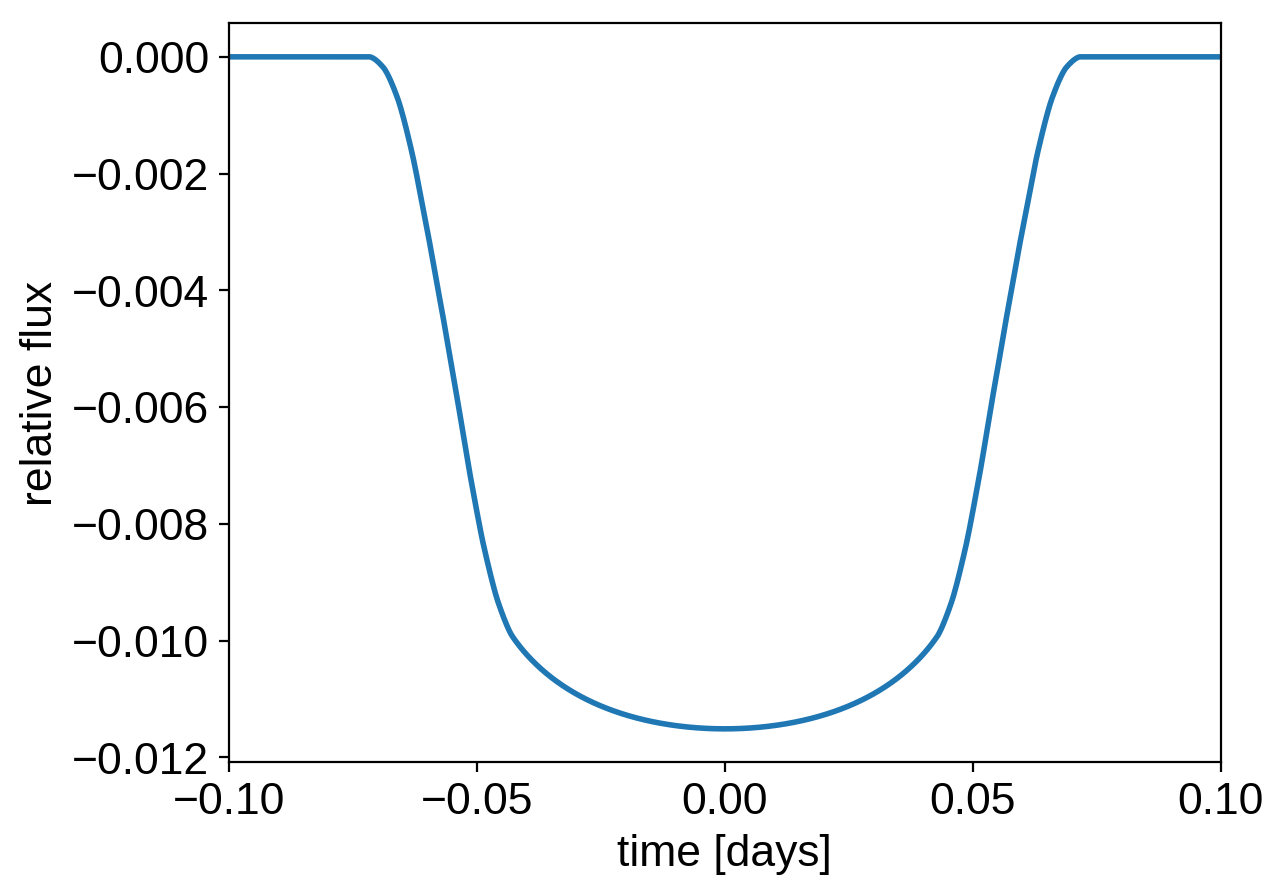

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.LimbDarkLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.1,
        testval_r=np.array([0.04, 0.06]),
        testval_b=np.random.rand(2)
    )
    
    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 24793.972586707856 -> 24799.526978939874


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

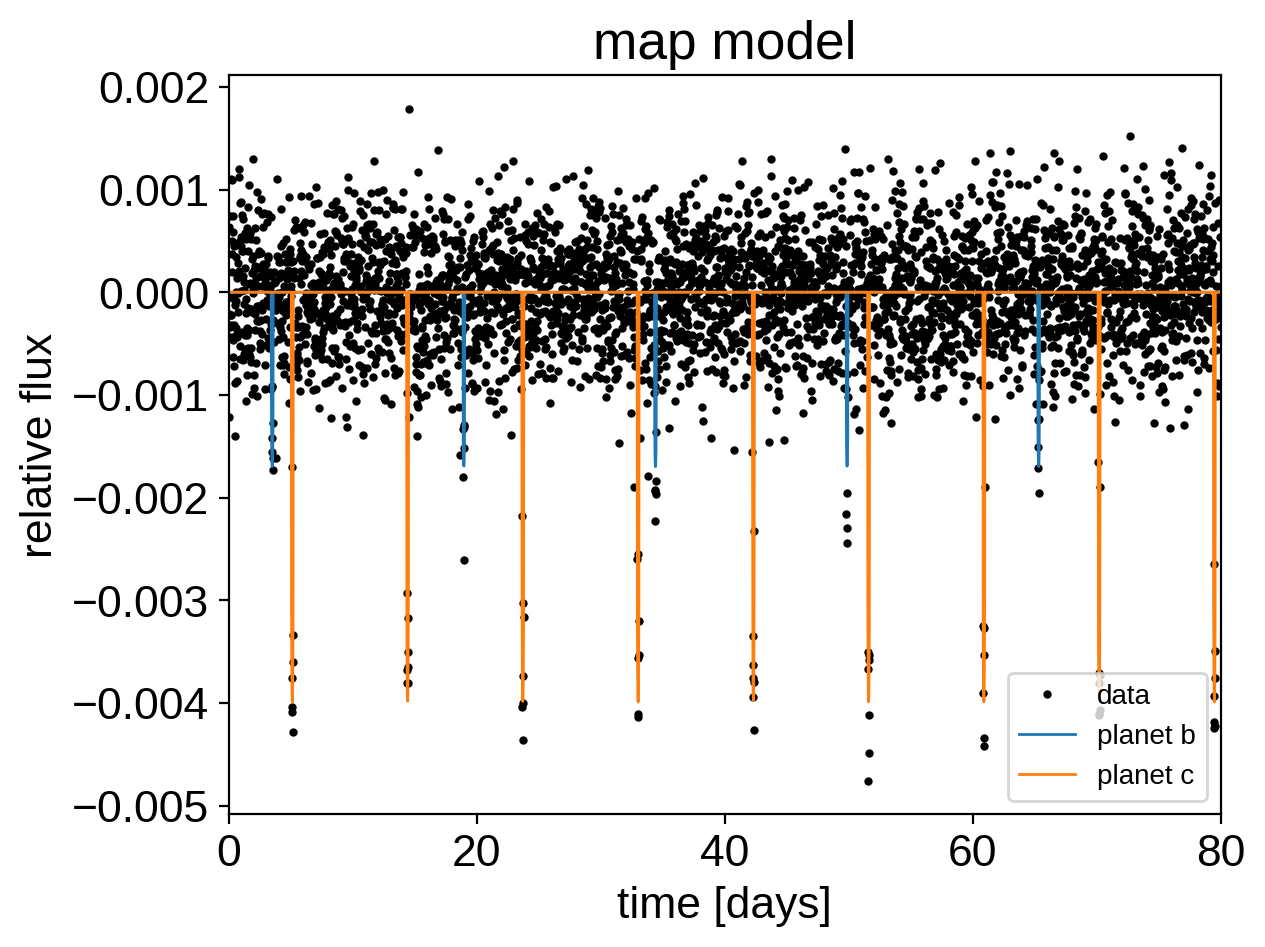

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200, chains=4)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:02, 127.38draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:00<00:04, 68.87draws/s] 

Sampling 4 chains:   9%|▉         | 29/308 [00:00<00:05, 52.11draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:00<00:06, 44.55draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:00<00:06, 40.43draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:00<00:07, 37.95draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:00<00:07, 36.41draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:01<00:07, 35.30draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:01<00:07, 34.24draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:01<00:07, 33.93draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:01<00:07, 33.72draws/s]

Sampling 4 chains:  21%|██▏       | 66/308 [00:01<00:07, 33.57draws/s]

Sampling 4 chains:  23%|██▎       | 70/308 [00:01<00:07, 33.47draws/s]

Sampling 4 chains:  24%|██▍       | 74/308 [00:01<00:07, 33.40draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:01<00:06, 33.35draws/s]

Sampling 4 chains:  27%|██▋       | 82/308 [00:02<00:06, 33.32draws/s]

Sampling 4 chains:  28%|██▊       | 86/308 [00:02<00:06, 33.21draws/s]

Sampling 4 chains:  29%|██▉       | 90/308 [00:02<00:06, 33.20draws/s]

Sampling 4 chains:  31%|███       | 96/308 [00:02<00:05, 36.90draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:02<00:05, 35.73draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:02<00:05, 34.95draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:02<00:05, 34.42draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:02<00:05, 34.06draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:02<00:05, 33.83draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:03<00:05, 33.66draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:03<00:05, 35.65draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:03<00:05, 34.73draws/s]

Sampling 4 chains:  44%|████▎     | 134/308 [00:03<00:04, 36.09draws/s]

Sampling 4 chains:  45%|████▍     | 138/308 [00:03<00:04, 35.17draws/s]

Sampling 4 chains:  46%|████▌     | 142/308 [00:03<00:04, 34.57draws/s]

Sampling 4 chains:  47%|████▋     | 146/308 [00:03<00:04, 34.15draws/s]

Sampling 4 chains:  49%|████▊     | 150/308 [00:03<00:04, 33.92draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [00:04<00:04, 33.75draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [00:04<00:04, 33.64draws/s]

Sampling 4 chains:  53%|█████▎    | 162/308 [00:04<00:04, 33.55draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:04<00:04, 33.50draws/s]

Sampling 4 chains:  55%|█████▌    | 170/308 [00:04<00:04, 33.29draws/s]

Sampling 4 chains:  56%|█████▋    | 174/308 [00:04<00:04, 33.32draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [00:04<00:03, 33.32draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [00:04<00:03, 33.33draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [00:05<00:03, 33.35draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [00:05<00:03, 33.37draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [00:05<00:03, 33.12draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [00:05<00:03, 33.19draws/s]

Sampling 4 chains:  66%|██████▌   | 202/308 [00:05<00:03, 33.24draws/s]

Sampling 4 chains:  67%|██████▋   | 206/308 [00:05<00:03, 33.28draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:05<00:02, 33.29draws/s]

Sampling 4 chains:  69%|██████▉   | 214/308 [00:05<00:02, 33.30draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:05<00:02, 33.30draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [00:06<00:02, 33.21draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:06<00:02, 32.12draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:06<00:02, 32.23draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [00:06<00:02, 32.92draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [00:06<00:02, 32.84draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:06<00:02, 32.80draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:06<00:01, 32.77draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:06<00:01, 32.74draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:07<00:01, 32.72draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:07<00:01, 32.71draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:07<00:01, 32.69draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:07<00:01, 32.67draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:07<00:01, 32.67draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:07<00:01, 32.68draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:07<00:00, 32.68draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:07<00:00, 32.29draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:08<00:00, 32.40draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:08<00:00, 32.49draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:08<00:00, 32.56draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:08<00:00, 32.62draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:08<00:00, 31.87draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:09<00:00, 17.25draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:09<00:00, 33.40draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 142.49draws/s]

Sampling 4 chains:   6%|▋         | 26/408 [00:00<00:04, 79.51draws/s] 

Sampling 4 chains:   8%|▊         | 31/408 [00:00<00:06, 57.76draws/s]

Sampling 4 chains:   9%|▊         | 35/408 [00:00<00:07, 49.46draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:00<00:08, 42.54draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:00<00:08, 40.59draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:00<00:09, 37.87draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:01<00:09, 36.08draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:01<00:09, 37.19draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:01<00:09, 35.52draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:01<00:09, 34.46draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:01<00:09, 37.34draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:01<00:09, 35.63draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:01<00:08, 36.91draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:01<00:09, 35.36draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:02<00:09, 34.34draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:02<00:08, 35.56draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:02<00:09, 33.00draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:02<00:08, 34.84draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:02<00:08, 33.99draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:02<00:08, 33.45draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:02<00:08, 35.25draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:02<00:08, 34.27draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:03<00:07, 37.55draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:03<00:07, 38.03draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:03<00:07, 36.11draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:03<00:07, 37.26draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:03<00:07, 35.45draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:03<00:06, 38.41draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:03<00:06, 38.95draws/s]

Sampling 4 chains:  39%|███▊      | 158/408 [00:03<00:06, 39.36draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:04<00:06, 36.91draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:04<00:06, 37.84draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:04<00:06, 35.95draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:04<00:05, 38.82draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:04<00:06, 36.64draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:04<00:06, 35.28draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:04<00:06, 33.86draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:04<00:06, 33.36draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:05<00:06, 33.03draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:05<00:06, 32.81draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:05<00:06, 32.68draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:05<00:06, 32.85draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:05<00:05, 32.64draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:05<00:05, 32.71draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:05<00:05, 32.60draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:05<00:05, 32.65draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:05<00:05, 34.79draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:06<00:04, 36.47draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:06<00:04, 35.30draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:06<00:04, 34.52draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:06<00:04, 34.00draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:06<00:04, 37.43draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:06<00:04, 35.91draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:06<00:03, 37.05draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:06<00:03, 38.15draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:07<00:03, 36.38draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:07<00:03, 37.66draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:07<00:03, 35.66draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:07<00:03, 36.69draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:07<00:03, 35.42draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:07<00:03, 34.41draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:07<00:03, 33.65draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:07<00:03, 33.40draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:08<00:03, 33.23draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:08<00:02, 34.09draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:08<00:02, 33.66draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:08<00:02, 33.38draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:08<00:02, 36.91draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:08<00:02, 35.52draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:08<00:02, 34.54draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:08<00:02, 33.86draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:09<00:02, 33.50draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:09<00:01, 33.23draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:09<00:01, 32.82draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:09<00:01, 34.78draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:09<00:01, 36.29draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:09<00:01, 34.99draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:09<00:01, 34.14draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:09<00:01, 33.58draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:10<00:00, 35.37draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:10<00:00, 34.45draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:10<00:00, 33.96draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:10<00:00, 33.62draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:10<00:00, 34.71draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:10<00:00, 35.66draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:10<00:00, 25.67draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:11<00:00, 24.79draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:11<00:00, 25.98draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:11<00:00, 34.92draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:57,  6.84draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<01:24,  9.39draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<01:06, 11.89draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:51, 15.30draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:43, 18.07draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:37, 21.00draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:31, 24.41draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:01<00:27, 28.20draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:01<00:26, 29.07draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:01<00:25, 29.71draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:01<00:20, 35.92draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:20, 36.37draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:18, 39.58draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:01<00:19, 37.01draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:01<00:18, 39.62draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:02<00:18, 39.90draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:02<00:17, 42.11draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:02<00:18, 37.61draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:02<00:16, 42.25draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:02<00:17, 41.05draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:02<00:17, 39.28draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:02<00:17, 39.61draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:02<00:16, 41.15draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:03<00:16, 40.48draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:03<00:15, 43.00draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:03<00:16, 40.71draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:03<00:16, 40.15draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:03<00:17, 37.67draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:03<00:18, 36.28draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:03<00:18, 36.32draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:03<00:17, 36.82draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:04<00:16, 39.34draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:04<00:18, 35.29draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:04<00:16, 38.60draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:04<00:16, 37.13draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:04<00:17, 35.19draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:04<00:16, 38.58draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:04<00:16, 37.79draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:05<00:15, 38.18draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:05<00:14, 40.59draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:05<00:14, 41.48draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:05<00:13, 44.51draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:05<00:12, 47.22draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:05<00:12, 44.36draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:05<00:13, 42.65draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:06<00:13, 41.16draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:06<00:13, 41.38draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:06<00:13, 42.07draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:06<00:13, 41.23draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:06<00:13, 39.60draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:06<00:14, 37.64draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:06<00:15, 35.08draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:06<00:15, 35.19draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:07<00:14, 36.09draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:07<00:13, 37.86draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:07<00:13, 39.41draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:07<00:13, 36.53draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:07<00:13, 37.32draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:07<00:12, 39.94draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:07<00:12, 40.45draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:07<00:12, 39.77draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:08<00:12, 39.33draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:08<00:12, 39.04draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:08<00:11, 43.00draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:08<00:11, 41.99draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:08<00:11, 40.47draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:08<00:11, 38.17draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:08<00:12, 35.85draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:08<00:13, 34.32draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:09<00:11, 37.19draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:09<00:11, 38.22draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:09<00:10, 40.84draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:09<00:09, 43.01draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:09<00:10, 39.27draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:09<00:10, 39.28draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:09<00:10, 39.29draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:10<00:11, 36.57draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:10<00:11, 35.53draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:10<00:10, 37.66draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [00:10<00:10, 36.73draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:10<00:10, 37.64draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:10<00:09, 41.36draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:10<00:08, 43.34draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:10<00:08, 45.01draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:10<00:09, 40.33draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:11<00:08, 44.38draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:11<00:07, 48.85draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:11<00:06, 50.17draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:11<00:07, 47.28draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:11<00:07, 46.51draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:11<00:07, 44.02draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:11<00:07, 44.56draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:11<00:06, 48.51draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:12<00:06, 48.15draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:12<00:06, 46.07draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:12<00:06, 43.33draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:12<00:06, 46.05draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:12<00:06, 43.40draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:12<00:05, 47.34draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:12<00:06, 46.14draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:12<00:06, 43.78draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:13<00:05, 44.82draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:13<00:06, 43.38draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [00:13<00:06, 41.91draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:13<00:06, 41.15draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:13<00:06, 40.83draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:13<00:05, 44.51draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:13<00:05, 44.26draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:13<00:04, 50.52draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:14<00:04, 45.53draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:14<00:04, 43.12draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:14<00:05, 41.58draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:14<00:04, 42.62draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:14<00:04, 47.09draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:14<00:03, 48.19draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:14<00:04, 41.10draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:15<00:04, 40.09draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:15<00:04, 41.87draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:15<00:04, 40.00draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:15<00:04, 39.75draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:15<00:03, 43.92draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:15<00:03, 42.21draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:15<00:03, 43.17draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:15<00:03, 43.28draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:16<00:03, 42.11draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:16<00:02, 47.48draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:16<00:03, 39.61draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [00:16<00:02, 39.73draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [00:16<00:02, 39.80draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [00:16<00:02, 39.84draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:16<00:02, 36.56draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:17<00:02, 40.68draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:17<00:02, 40.31draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:17<00:02, 41.24draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:17<00:02, 39.49draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:17<00:01, 38.90draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:17<00:01, 41.12draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [00:17<00:01, 40.44draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:17<00:01, 39.36draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:18<00:01, 40.57draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [00:18<00:01, 40.22draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:18<00:00, 46.48draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:18<00:00, 40.42draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [00:18<00:00, 35.62draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:18<00:00, 36.03draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [00:19<00:00, 33.19draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:19<00:00, 38.82draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:19<00:00, 36.36draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:19<00:00, 31.06draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:19<00:00, 40.90draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:00<00:05, 288.97draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:00<00:05, 304.73draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:00<00:04, 333.30draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:00<00:04, 358.92draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:00<00:03, 386.80draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:00<00:03, 416.73draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:00<00:03, 428.70draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:00<00:02, 456.68draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:00<00:02, 463.31draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [00:01<00:02, 467.85draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:01<00:02, 478.07draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:01<00:02, 493.75draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [00:01<00:02, 488.37draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [00:01<00:01, 499.10draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [00:01<00:01, 504.20draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [00:01<00:01, 512.78draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [00:01<00:01, 503.09draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [00:01<00:01, 506.83draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [00:01<00:01, 529.86draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [00:02<00:01, 523.39draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [00:02<00:01, 527.89draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [00:02<00:00, 529.23draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [00:02<00:00, 537.84draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [00:02<00:00, 538.99draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [00:02<00:00, 536.95draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [00:02<00:00, 527.02draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [00:02<00:00, 529.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [00:02<00:00, 504.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [00:02<00:00, 515.99draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [00:03<00:00, 515.35draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [00:03<00:00, 503.50draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 474.59draws/s]

Sampling 4 chains:   0%|          | 0/6908 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 32/6908 [00:00<00:21, 317.71draws/s]

Sampling 4 chains:   1%|          | 70/6908 [00:00<00:20, 330.58draws/s]

Sampling 4 chains:   2%|▏         | 106/6908 [00:00<00:20, 338.74draws/s]

Sampling 4 chains:   2%|▏         | 142/6908 [00:00<00:19, 343.54draws/s]

Sampling 4 chains:   3%|▎         | 175/6908 [00:00<00:19, 338.94draws/s]

Sampling 4 chains:   3%|▎         | 212/6908 [00:00<00:19, 346.59draws/s]

Sampling 4 chains:   4%|▎         | 253/6908 [00:00<00:18, 362.40draws/s]

Sampling 4 chains:   4%|▍         | 298/6908 [00:00<00:17, 382.42draws/s]

Sampling 4 chains:   5%|▌         | 349/6908 [00:00<00:15, 413.14draws/s]

Sampling 4 chains:   6%|▌         | 391/6908 [00:01<00:15, 411.70draws/s]

Sampling 4 chains:   6%|▋         | 436/6908 [00:01<00:15, 420.04draws/s]

Sampling 4 chains:   7%|▋         | 478/6908 [00:01<00:15, 419.95draws/s]

Sampling 4 chains:   8%|▊         | 530/6908 [00:01<00:14, 444.30draws/s]

Sampling 4 chains:   8%|▊         | 577/6908 [00:01<00:14, 451.68draws/s]

Sampling 4 chains:   9%|▉         | 623/6908 [00:01<00:14, 443.48draws/s]

Sampling 4 chains:  10%|▉         | 668/6908 [00:01<00:14, 438.16draws/s]

Sampling 4 chains:  10%|█         | 719/6908 [00:01<00:13, 455.16draws/s]

Sampling 4 chains:  11%|█         | 772/6908 [00:01<00:12, 473.01draws/s]

Sampling 4 chains:  12%|█▏        | 828/6908 [00:01<00:12, 496.04draws/s]

Sampling 4 chains:  13%|█▎        | 879/6908 [00:02<00:12, 490.44draws/s]

Sampling 4 chains:  13%|█▎        | 930/6908 [00:02<00:12, 490.58draws/s]

Sampling 4 chains:  14%|█▍        | 980/6908 [00:02<00:12, 488.71draws/s]

Sampling 4 chains:  15%|█▍        | 1030/6908 [00:02<00:12, 484.95draws/s]

Sampling 4 chains:  16%|█▌        | 1079/6908 [00:02<00:12, 475.45draws/s]

Sampling 4 chains:  16%|█▋        | 1127/6908 [00:02<00:12, 469.43draws/s]

Sampling 4 chains:  17%|█▋        | 1180/6908 [00:02<00:11, 484.81draws/s]

Sampling 4 chains:  18%|█▊        | 1230/6908 [00:02<00:11, 485.94draws/s]

Sampling 4 chains:  19%|█▊        | 1282/6908 [00:02<00:11, 493.84draws/s]

Sampling 4 chains:  19%|█▉        | 1334/6908 [00:02<00:11, 500.55draws/s]

Sampling 4 chains:  20%|██        | 1385/6908 [00:03<00:11, 492.54draws/s]

Sampling 4 chains:  21%|██        | 1435/6908 [00:03<00:11, 477.17draws/s]

Sampling 4 chains:  21%|██▏       | 1485/6908 [00:03<00:11, 480.60draws/s]

Sampling 4 chains:  22%|██▏       | 1538/6908 [00:03<00:10, 489.17draws/s]

Sampling 4 chains:  23%|██▎       | 1588/6908 [00:03<00:10, 485.18draws/s]

Sampling 4 chains:  24%|██▎       | 1639/6908 [00:03<00:10, 492.04draws/s]

Sampling 4 chains:  24%|██▍       | 1689/6908 [00:03<00:10, 482.35draws/s]

Sampling 4 chains:  25%|██▌       | 1741/6908 [00:03<00:10, 492.70draws/s]

Sampling 4 chains:  26%|██▌       | 1795/6908 [00:03<00:10, 504.55draws/s]

Sampling 4 chains:  27%|██▋       | 1846/6908 [00:04<00:10, 488.29draws/s]

Sampling 4 chains:  27%|██▋       | 1896/6908 [00:04<00:10, 490.41draws/s]

Sampling 4 chains:  28%|██▊       | 1946/6908 [00:04<00:10, 479.24draws/s]

Sampling 4 chains:  29%|██▉       | 1998/6908 [00:04<00:10, 489.36draws/s]

Sampling 4 chains:  30%|██▉       | 2051/6908 [00:04<00:09, 500.11draws/s]

Sampling 4 chains:  30%|███       | 2102/6908 [00:04<00:09, 485.64draws/s]

Sampling 4 chains:  31%|███       | 2154/6908 [00:04<00:09, 494.03draws/s]

Sampling 4 chains:  32%|███▏      | 2207/6908 [00:04<00:09, 502.17draws/s]

Sampling 4 chains:  33%|███▎      | 2258/6908 [00:04<00:09, 488.37draws/s]

Sampling 4 chains:  34%|███▎      | 2315/6908 [00:04<00:09, 508.26draws/s]

Sampling 4 chains:  34%|███▍      | 2367/6908 [00:05<00:09, 474.62draws/s]

Sampling 4 chains:  35%|███▌      | 2418/6908 [00:05<00:09, 483.02draws/s]

Sampling 4 chains:  36%|███▌      | 2471/6908 [00:05<00:08, 495.11draws/s]

Sampling 4 chains:  37%|███▋      | 2522/6908 [00:05<00:08, 497.28draws/s]

Sampling 4 chains:  37%|███▋      | 2576/6908 [00:05<00:08, 507.99draws/s]

Sampling 4 chains:  38%|███▊      | 2628/6908 [00:05<00:08, 511.49draws/s]

Sampling 4 chains:  39%|███▉      | 2684/6908 [00:05<00:08, 524.20draws/s]

Sampling 4 chains:  40%|███▉      | 2737/6908 [00:05<00:08, 500.88draws/s]

Sampling 4 chains:  40%|████      | 2788/6908 [00:05<00:08, 502.26draws/s]

Sampling 4 chains:  41%|████      | 2839/6908 [00:06<00:08, 498.15draws/s]

Sampling 4 chains:  42%|████▏     | 2890/6908 [00:06<00:08, 497.87draws/s]

Sampling 4 chains:  43%|████▎     | 2940/6908 [00:06<00:08, 495.38draws/s]

Sampling 4 chains:  43%|████▎     | 2991/6908 [00:06<00:07, 499.55draws/s]

Sampling 4 chains:  44%|████▍     | 3043/6908 [00:06<00:07, 505.31draws/s]

Sampling 4 chains:  45%|████▍     | 3100/6908 [00:06<00:07, 522.67draws/s]

Sampling 4 chains:  46%|████▌     | 3155/6908 [00:06<00:07, 529.74draws/s]

Sampling 4 chains:  46%|████▋     | 3211/6908 [00:06<00:06, 537.69draws/s]

Sampling 4 chains:  47%|████▋     | 3265/6908 [00:06<00:06, 532.27draws/s]

Sampling 4 chains:  48%|████▊     | 3320/6908 [00:06<00:06, 537.20draws/s]

Sampling 4 chains:  49%|████▉     | 3374/6908 [00:07<00:06, 532.82draws/s]

Sampling 4 chains:  50%|████▉     | 3428/6908 [00:07<00:06, 521.42draws/s]

Sampling 4 chains:  50%|█████     | 3481/6908 [00:07<00:06, 510.66draws/s]

Sampling 4 chains:  51%|█████     | 3533/6908 [00:07<00:06, 503.09draws/s]

Sampling 4 chains:  52%|█████▏    | 3585/6908 [00:07<00:06, 507.62draws/s]

Sampling 4 chains:  53%|█████▎    | 3638/6908 [00:07<00:06, 512.67draws/s]

Sampling 4 chains:  53%|█████▎    | 3691/6908 [00:07<00:06, 516.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3743/6908 [00:07<00:06, 493.79draws/s]

Sampling 4 chains:  55%|█████▍    | 3795/6908 [00:07<00:06, 499.78draws/s]

Sampling 4 chains:  56%|█████▌    | 3847/6908 [00:07<00:06, 502.20draws/s]

Sampling 4 chains:  56%|█████▋    | 3900/6908 [00:08<00:05, 509.56draws/s]

Sampling 4 chains:  57%|█████▋    | 3952/6908 [00:08<00:05, 495.61draws/s]

Sampling 4 chains:  58%|█████▊    | 4004/6908 [00:08<00:05, 499.17draws/s]

Sampling 4 chains:  59%|█████▊    | 4055/6908 [00:08<00:05, 498.49draws/s]

Sampling 4 chains:  59%|█████▉    | 4110/6908 [00:08<00:05, 510.19draws/s]

Sampling 4 chains:  60%|██████    | 4162/6908 [00:08<00:05, 500.64draws/s]

Sampling 4 chains:  61%|██████    | 4213/6908 [00:08<00:05, 478.20draws/s]

Sampling 4 chains:  62%|██████▏   | 4262/6908 [00:08<00:05, 474.56draws/s]

Sampling 4 chains:  62%|██████▏   | 4314/6908 [00:08<00:05, 483.52draws/s]

Sampling 4 chains:  63%|██████▎   | 4365/6908 [00:09<00:05, 490.71draws/s]

Sampling 4 chains:  64%|██████▍   | 4415/6908 [00:09<00:05, 491.87draws/s]

Sampling 4 chains:  65%|██████▍   | 4468/6908 [00:09<00:04, 501.79draws/s]

Sampling 4 chains:  66%|██████▌   | 4528/6908 [00:09<00:04, 527.47draws/s]

Sampling 4 chains:  66%|██████▋   | 4582/6908 [00:09<00:04, 513.08draws/s]

Sampling 4 chains:  67%|██████▋   | 4634/6908 [00:09<00:04, 512.78draws/s]

Sampling 4 chains:  68%|██████▊   | 4686/6908 [00:09<00:04, 495.96draws/s]

Sampling 4 chains:  69%|██████▊   | 4736/6908 [00:09<00:04, 495.30draws/s]

Sampling 4 chains:  69%|██████▉   | 4786/6908 [00:09<00:04, 491.32draws/s]

Sampling 4 chains:  70%|███████   | 4836/6908 [00:09<00:04, 491.33draws/s]

Sampling 4 chains:  71%|███████   | 4887/6908 [00:10<00:04, 496.09draws/s]

Sampling 4 chains:  71%|███████▏  | 4939/6908 [00:10<00:03, 500.10draws/s]

Sampling 4 chains:  72%|███████▏  | 4990/6908 [00:10<00:03, 493.77draws/s]

Sampling 4 chains:  73%|███████▎  | 5042/6908 [00:10<00:03, 498.26draws/s]

Sampling 4 chains:  74%|███████▎  | 5092/6908 [00:10<00:03, 497.93draws/s]

Sampling 4 chains:  74%|███████▍  | 5142/6908 [00:10<00:03, 489.14draws/s]

Sampling 4 chains:  75%|███████▌  | 5195/6908 [00:10<00:03, 498.34draws/s]

Sampling 4 chains:  76%|███████▌  | 5245/6908 [00:10<00:03, 486.55draws/s]

Sampling 4 chains:  77%|███████▋  | 5294/6908 [00:10<00:03, 486.38draws/s]

Sampling 4 chains:  77%|███████▋  | 5347/6908 [00:10<00:03, 498.30draws/s]

Sampling 4 chains:  78%|███████▊  | 5397/6908 [00:11<00:03, 496.81draws/s]

Sampling 4 chains:  79%|███████▉  | 5448/6908 [00:11<00:02, 500.00draws/s]

Sampling 4 chains:  80%|███████▉  | 5499/6908 [00:11<00:02, 502.30draws/s]

Sampling 4 chains:  80%|████████  | 5550/6908 [00:11<00:02, 488.53draws/s]

Sampling 4 chains:  81%|████████  | 5599/6908 [00:11<00:02, 479.08draws/s]

Sampling 4 chains:  82%|████████▏ | 5651/6908 [00:11<00:02, 487.09draws/s]

Sampling 4 chains:  83%|████████▎ | 5706/6908 [00:11<00:02, 498.96draws/s]

Sampling 4 chains:  83%|████████▎ | 5757/6908 [00:11<00:02, 496.81draws/s]

Sampling 4 chains:  84%|████████▍ | 5813/6908 [00:11<00:02, 513.32draws/s]

Sampling 4 chains:  85%|████████▍ | 5865/6908 [00:12<00:02, 510.75draws/s]

Sampling 4 chains:  86%|████████▌ | 5917/6908 [00:12<00:01, 503.98draws/s]

Sampling 4 chains:  86%|████████▋ | 5972/6908 [00:12<00:01, 512.79draws/s]

Sampling 4 chains:  87%|████████▋ | 6026/6908 [00:12<00:01, 517.26draws/s]

Sampling 4 chains:  88%|████████▊ | 6081/6908 [00:12<00:01, 521.97draws/s]

Sampling 4 chains:  89%|████████▉ | 6134/6908 [00:12<00:01, 516.35draws/s]

Sampling 4 chains:  90%|████████▉ | 6186/6908 [00:12<00:01, 503.93draws/s]

Sampling 4 chains:  90%|█████████ | 6237/6908 [00:12<00:01, 504.11draws/s]

Sampling 4 chains:  91%|█████████ | 6288/6908 [00:12<00:01, 498.48draws/s]

Sampling 4 chains:  92%|█████████▏| 6338/6908 [00:12<00:01, 486.10draws/s]

Sampling 4 chains:  93%|█████████▎| 6390/6908 [00:13<00:01, 492.71draws/s]

Sampling 4 chains:  93%|█████████▎| 6440/6908 [00:13<00:00, 491.37draws/s]

Sampling 4 chains:  94%|█████████▍| 6491/6908 [00:13<00:00, 493.62draws/s]

Sampling 4 chains:  95%|█████████▍| 6543/6908 [00:13<00:00, 498.25draws/s]

Sampling 4 chains:  96%|█████████▌| 6598/6908 [00:13<00:00, 512.17draws/s]

Sampling 4 chains:  96%|█████████▋| 6650/6908 [00:13<00:00, 505.27draws/s]

Sampling 4 chains:  97%|█████████▋| 6701/6908 [00:13<00:00, 503.21draws/s]

Sampling 4 chains:  98%|█████████▊| 6752/6908 [00:13<00:00, 496.84draws/s]

Sampling 4 chains:  98%|█████████▊| 6802/6908 [00:13<00:00, 477.97draws/s]

Sampling 4 chains:  99%|█████████▉| 6851/6908 [00:14<00:00, 439.73draws/s]

Sampling 4 chains: 100%|█████████▉| 6896/6908 [00:14<00:00, 333.63draws/s]

Sampling 4 chains: 100%|██████████| 6908/6908 [00:14<00:00, 481.24draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:00<00:03, 255.49draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:00<00:02, 277.87draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:00<00:02, 282.40draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:00<00:02, 287.33draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:00<00:02, 309.75draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:00<00:02, 304.03draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:00<00:01, 326.65draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:00<00:01, 336.46draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:00<00:01, 341.04draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:01<00:01, 365.02draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:01<00:01, 398.60draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [00:01<00:00, 398.24draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:01<00:00, 416.83draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:01<00:00, 420.53draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:01<00:00, 445.90draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:01<00:00, 467.97draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [00:01<00:00, 460.94draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:01<00:00, 452.37draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:02<00:00, 340.79draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 342.76draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [rb, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 37/12000 [00:00<00:32, 369.82draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:00<00:29, 400.95draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:00<00:27, 428.59draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [00:00<00:26, 453.18draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [00:00<00:25, 463.41draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [00:00<00:24, 477.98draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [00:00<00:23, 489.12draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [00:00<00:23, 498.17draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [00:00<00:23, 495.84draws/s]

Sampling 4 chains:   4%|▍         | 502/12000 [00:01<00:23, 493.74draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [00:01<00:23, 494.29draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [00:01<00:22, 495.69draws/s]

Sampling 4 chains:   5%|▌         | 655/12000 [00:01<00:22, 501.49draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [00:01<00:22, 506.22draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [00:01<00:22, 500.99draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [00:01<00:22, 499.35draws/s]

Sampling 4 chains:   7%|▋         | 859/12000 [00:01<00:22, 497.68draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [00:01<00:22, 498.43draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [00:01<00:21, 504.97draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [00:02<00:21, 505.94draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [00:02<00:21, 509.39draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [00:02<00:21, 508.53draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [00:02<00:21, 506.57draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [00:02<00:21, 511.30draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [00:02<00:21, 504.15draws/s]

Sampling 4 chains:  11%|█         | 1325/12000 [00:02<00:21, 495.70draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [00:02<00:21, 499.85draws/s]

Sampling 4 chains:  12%|█▏        | 1427/12000 [00:02<00:21, 496.69draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [00:02<00:21, 493.47draws/s]

Sampling 4 chains:  13%|█▎        | 1528/12000 [00:03<00:21, 497.65draws/s]

Sampling 4 chains:  13%|█▎        | 1578/12000 [00:03<00:21, 489.03draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [00:03<00:21, 491.90draws/s]

Sampling 4 chains:  14%|█▍        | 1679/12000 [00:03<00:20, 495.61draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [00:03<00:20, 502.67draws/s]

Sampling 4 chains:  15%|█▍        | 1783/12000 [00:03<00:20, 504.77draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [00:03<00:20, 506.18draws/s]

Sampling 4 chains:  16%|█▌        | 1886/12000 [00:03<00:19, 508.78draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [00:03<00:19, 507.23draws/s]

Sampling 4 chains:  17%|█▋        | 1988/12000 [00:03<00:20, 496.67draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [00:04<00:19, 498.88draws/s]

Sampling 4 chains:  17%|█▋        | 2090/12000 [00:04<00:19, 501.87draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [00:04<00:19, 499.71draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [00:04<00:19, 507.57draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [00:04<00:18, 515.08draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [00:04<00:18, 518.30draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [00:04<00:18, 515.55draws/s]

Sampling 4 chains:  20%|██        | 2405/12000 [00:04<00:19, 504.20draws/s]

Sampling 4 chains:  20%|██        | 2458/12000 [00:04<00:18, 511.30draws/s]

Sampling 4 chains:  21%|██        | 2510/12000 [00:05<00:18, 506.52draws/s]

Sampling 4 chains:  21%|██▏       | 2562/12000 [00:05<00:18, 509.44draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [00:05<00:18, 510.76draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [00:05<00:18, 511.84draws/s]

Sampling 4 chains:  23%|██▎       | 2719/12000 [00:05<00:18, 509.03draws/s]

Sampling 4 chains:  23%|██▎       | 2770/12000 [00:05<00:18, 501.39draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [00:05<00:18, 496.53draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [00:05<00:18, 502.94draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [00:05<00:17, 510.07draws/s]

Sampling 4 chains:  25%|██▍       | 2979/12000 [00:05<00:17, 501.43draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [00:06<00:17, 502.12draws/s]

Sampling 4 chains:  26%|██▌       | 3081/12000 [00:06<00:17, 499.13draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [00:06<00:17, 493.69draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [00:06<00:17, 500.28draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [00:06<00:17, 501.17draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [00:06<00:17, 506.44draws/s]

Sampling 4 chains:  28%|██▊       | 3339/12000 [00:06<00:17, 504.10draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [00:06<00:16, 508.29draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [00:06<00:16, 509.91draws/s]

Sampling 4 chains:  29%|██▉       | 3496/12000 [00:06<00:16, 514.45draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [00:07<00:16, 504.27draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [00:07<00:16, 510.67draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [00:07<00:16, 513.19draws/s]

Sampling 4 chains:  31%|███       | 3706/12000 [00:07<00:16, 514.21draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [00:07<00:15, 515.60draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [00:07<00:15, 522.58draws/s]

Sampling 4 chains:  32%|███▏      | 3866/12000 [00:07<00:15, 518.50draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [00:07<00:15, 524.43draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [00:07<00:15, 519.64draws/s]

Sampling 4 chains:  34%|███▎      | 4026/12000 [00:07<00:15, 520.21draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [00:08<00:15, 508.05draws/s]

Sampling 4 chains:  34%|███▍      | 4134/12000 [00:08<00:15, 517.58draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [00:08<00:15, 519.72draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [00:08<00:14, 518.23draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [00:08<00:14, 520.06draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [00:08<00:14, 521.27draws/s]

Sampling 4 chains:  37%|███▋      | 4400/12000 [00:08<00:14, 518.62draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [00:08<00:14, 518.90draws/s]

Sampling 4 chains:  38%|███▊      | 4505/12000 [00:08<00:14, 515.41draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [00:09<00:14, 504.68draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [00:09<00:14, 510.83draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [00:09<00:14, 512.91draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [00:09<00:14, 518.20draws/s]

Sampling 4 chains:  40%|███▉      | 4772/12000 [00:09<00:13, 521.53draws/s]

Sampling 4 chains:  40%|████      | 4826/12000 [00:09<00:13, 521.78draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [00:09<00:13, 512.35draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [00:09<00:14, 504.13draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [00:09<00:13, 503.32draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [00:09<00:13, 506.06draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [00:10<00:13, 512.04draws/s]

Sampling 4 chains:  43%|████▎     | 5140/12000 [00:10<00:13, 508.32draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [00:10<00:13, 506.64draws/s]

Sampling 4 chains:  44%|████▎     | 5242/12000 [00:10<00:13, 506.65draws/s]

Sampling 4 chains:  44%|████▍     | 5293/12000 [00:10<00:13, 502.85draws/s]

Sampling 4 chains:  45%|████▍     | 5345/12000 [00:10<00:13, 506.44draws/s]

Sampling 4 chains:  45%|████▍     | 5396/12000 [00:10<00:13, 503.31draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [00:10<00:13, 499.60draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [00:10<00:13, 497.94draws/s]

Sampling 4 chains:  46%|████▌     | 5547/12000 [00:10<00:13, 488.64draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [00:11<00:13, 489.04draws/s]

Sampling 4 chains:  47%|████▋     | 5645/12000 [00:11<00:13, 485.01draws/s]

Sampling 4 chains:  47%|████▋     | 5697/12000 [00:11<00:12, 493.94draws/s]

Sampling 4 chains:  48%|████▊     | 5749/12000 [00:11<00:12, 498.74draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [00:11<00:12, 501.02draws/s]

Sampling 4 chains:  49%|████▉     | 5852/12000 [00:11<00:12, 502.91draws/s]

Sampling 4 chains:  49%|████▉     | 5905/12000 [00:11<00:11, 510.10draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [00:11<00:11, 509.52draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [00:11<00:11, 503.16draws/s]

Sampling 4 chains:  51%|█████     | 6063/12000 [00:11<00:11, 515.33draws/s]

Sampling 4 chains:  51%|█████     | 6115/12000 [00:12<00:11, 495.30draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [00:12<00:11, 499.88draws/s]

Sampling 4 chains:  52%|█████▏    | 6220/12000 [00:12<00:11, 507.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [00:12<00:11, 509.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [00:12<00:11, 508.88draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [00:12<00:11, 503.45draws/s]

Sampling 4 chains:  54%|█████▎    | 6426/12000 [00:12<00:11, 502.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6477/12000 [00:12<00:10, 504.38draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [00:12<00:10, 501.71draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [00:13<00:10, 501.56draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [00:13<00:10, 498.21draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [00:13<00:10, 506.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [00:13<00:10, 505.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6790/12000 [00:13<00:10, 513.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [00:13<00:10, 514.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [00:13<00:09, 519.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [00:13<00:09, 513.73draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [00:13<00:09, 516.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [00:13<00:09, 514.94draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [00:14<00:09, 506.41draws/s]

Sampling 4 chains:  60%|█████▉    | 7157/12000 [00:14<00:09, 504.63draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [00:14<00:09, 502.53draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [00:14<00:09, 508.78draws/s]

Sampling 4 chains:  61%|██████    | 7317/12000 [00:14<00:09, 519.64draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [00:14<00:09, 509.69draws/s]

Sampling 4 chains:  62%|██████▏   | 7422/12000 [00:14<00:08, 511.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [00:14<00:08, 511.17draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [00:14<00:08, 519.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [00:14<00:08, 519.28draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [00:15<00:08, 512.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [00:15<00:08, 509.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [00:15<00:08, 518.25draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [00:15<00:08, 514.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [00:15<00:08, 514.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7894/12000 [00:15<00:08, 509.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7947/12000 [00:15<00:07, 511.84draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [00:15<00:07, 506.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [00:15<00:07, 509.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [00:15<00:07, 516.85draws/s]

Sampling 4 chains:  68%|██████▊   | 8157/12000 [00:16<00:07, 516.92draws/s]

Sampling 4 chains:  68%|██████▊   | 8210/12000 [00:16<00:07, 515.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [00:16<00:07, 523.72draws/s]

Sampling 4 chains:  69%|██████▉   | 8318/12000 [00:16<00:07, 516.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [00:16<00:07, 513.48draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [00:16<00:06, 519.55draws/s]

Sampling 4 chains:  71%|███████   | 8477/12000 [00:16<00:06, 513.81draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [00:16<00:06, 514.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [00:16<00:06, 511.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [00:17<00:06, 515.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [00:17<00:06, 519.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [00:17<00:06, 521.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8795/12000 [00:17<00:06, 522.74draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [00:17<00:06, 515.37draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [00:17<00:05, 522.41draws/s]

Sampling 4 chains:  75%|███████▍  | 8955/12000 [00:17<00:05, 516.32draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [00:17<00:05, 524.46draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [00:17<00:05, 515.54draws/s]

Sampling 4 chains:  76%|███████▌  | 9115/12000 [00:17<00:05, 512.78draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [00:18<00:05, 520.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9222/12000 [00:18<00:05, 510.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [00:18<00:05, 503.05draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [00:18<00:05, 500.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [00:18<00:05, 502.26draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [00:18<00:05, 508.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [00:18<00:04, 513.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9535/12000 [00:18<00:04, 505.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [00:18<00:04, 510.72draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [00:18<00:04, 510.78draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [00:19<00:04, 509.84draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [00:19<00:04, 517.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [00:19<00:04, 517.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [00:19<00:04, 520.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [00:19<00:04, 513.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9957/12000 [00:19<00:03, 514.04draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [00:19<00:03, 513.33draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [00:19<00:03, 514.23draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [00:19<00:03, 513.54draws/s]

Sampling 4 chains:  85%|████████▍ | 10165/12000 [00:19<00:03, 513.68draws/s]

Sampling 4 chains:  85%|████████▌ | 10217/12000 [00:20<00:03, 510.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10270/12000 [00:20<00:03, 513.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [00:20<00:03, 517.51draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [00:20<00:03, 517.27draws/s]

Sampling 4 chains:  87%|████████▋ | 10427/12000 [00:20<00:03, 517.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [00:20<00:02, 520.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [00:20<00:02, 515.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10588/12000 [00:20<00:02, 518.90draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [00:20<00:02, 516.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [00:21<00:02, 515.32draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [00:21<00:02, 516.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [00:21<00:02, 513.62draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [00:21<00:02, 514.09draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [00:21<00:02, 503.88draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [00:21<00:02, 510.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [00:21<00:01, 510.17draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [00:21<00:01, 514.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [00:21<00:01, 508.54draws/s]

Sampling 4 chains:  93%|█████████▎| 11163/12000 [00:21<00:01, 510.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [00:22<00:01, 518.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11269/12000 [00:22<00:01, 509.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11321/12000 [00:22<00:01, 504.69draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [00:22<00:01, 508.51draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [00:22<00:01, 497.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [00:22<00:01, 496.42draws/s]

Sampling 4 chains:  96%|█████████▌| 11524/12000 [00:22<00:00, 495.81draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [00:22<00:00, 502.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [00:22<00:00, 508.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11682/12000 [00:22<00:00, 511.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11735/12000 [00:23<00:00, 516.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11789/12000 [00:23<00:00, 520.41draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [00:23<00:00, 519.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [00:23<00:00, 460.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [00:23<00:00, 345.65draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [00:23<00:00, 217.14draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 496.79draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447914,0.002321,3.659947e-05,15.443122,15.452090,4385.443009,1.000574
period__1,9.292474,0.000301,2.808500e-06,9.291887,9.293050,12151.835330,0.999905
t0__0,3.503112,0.005837,9.350475e-05,3.492809,3.515157,4438.396882,1.000357
t0__1,5.121289,0.001370,1.149626e-05,5.118693,5.124023,13671.770308,0.999898
r__0,0.039526,0.001599,2.164871e-05,0.036400,0.042555,5932.885111,1.000028
r__1,0.058462,0.001054,1.516423e-05,0.056437,0.060415,5619.543688,1.000414
b__0,0.668522,0.047575,8.550631e-04,0.566165,0.738892,3357.794852,1.000184
b__1,0.402511,0.038414,5.352225e-04,0.324421,0.467398,5436.914504,1.000321
u__0,0.369271,0.206921,2.480988e-03,0.000376,0.727056,8685.453309,1.000082
u__1,0.283749,0.340357,4.995744e-03,-0.321040,0.871783,5649.580001,1.000259


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

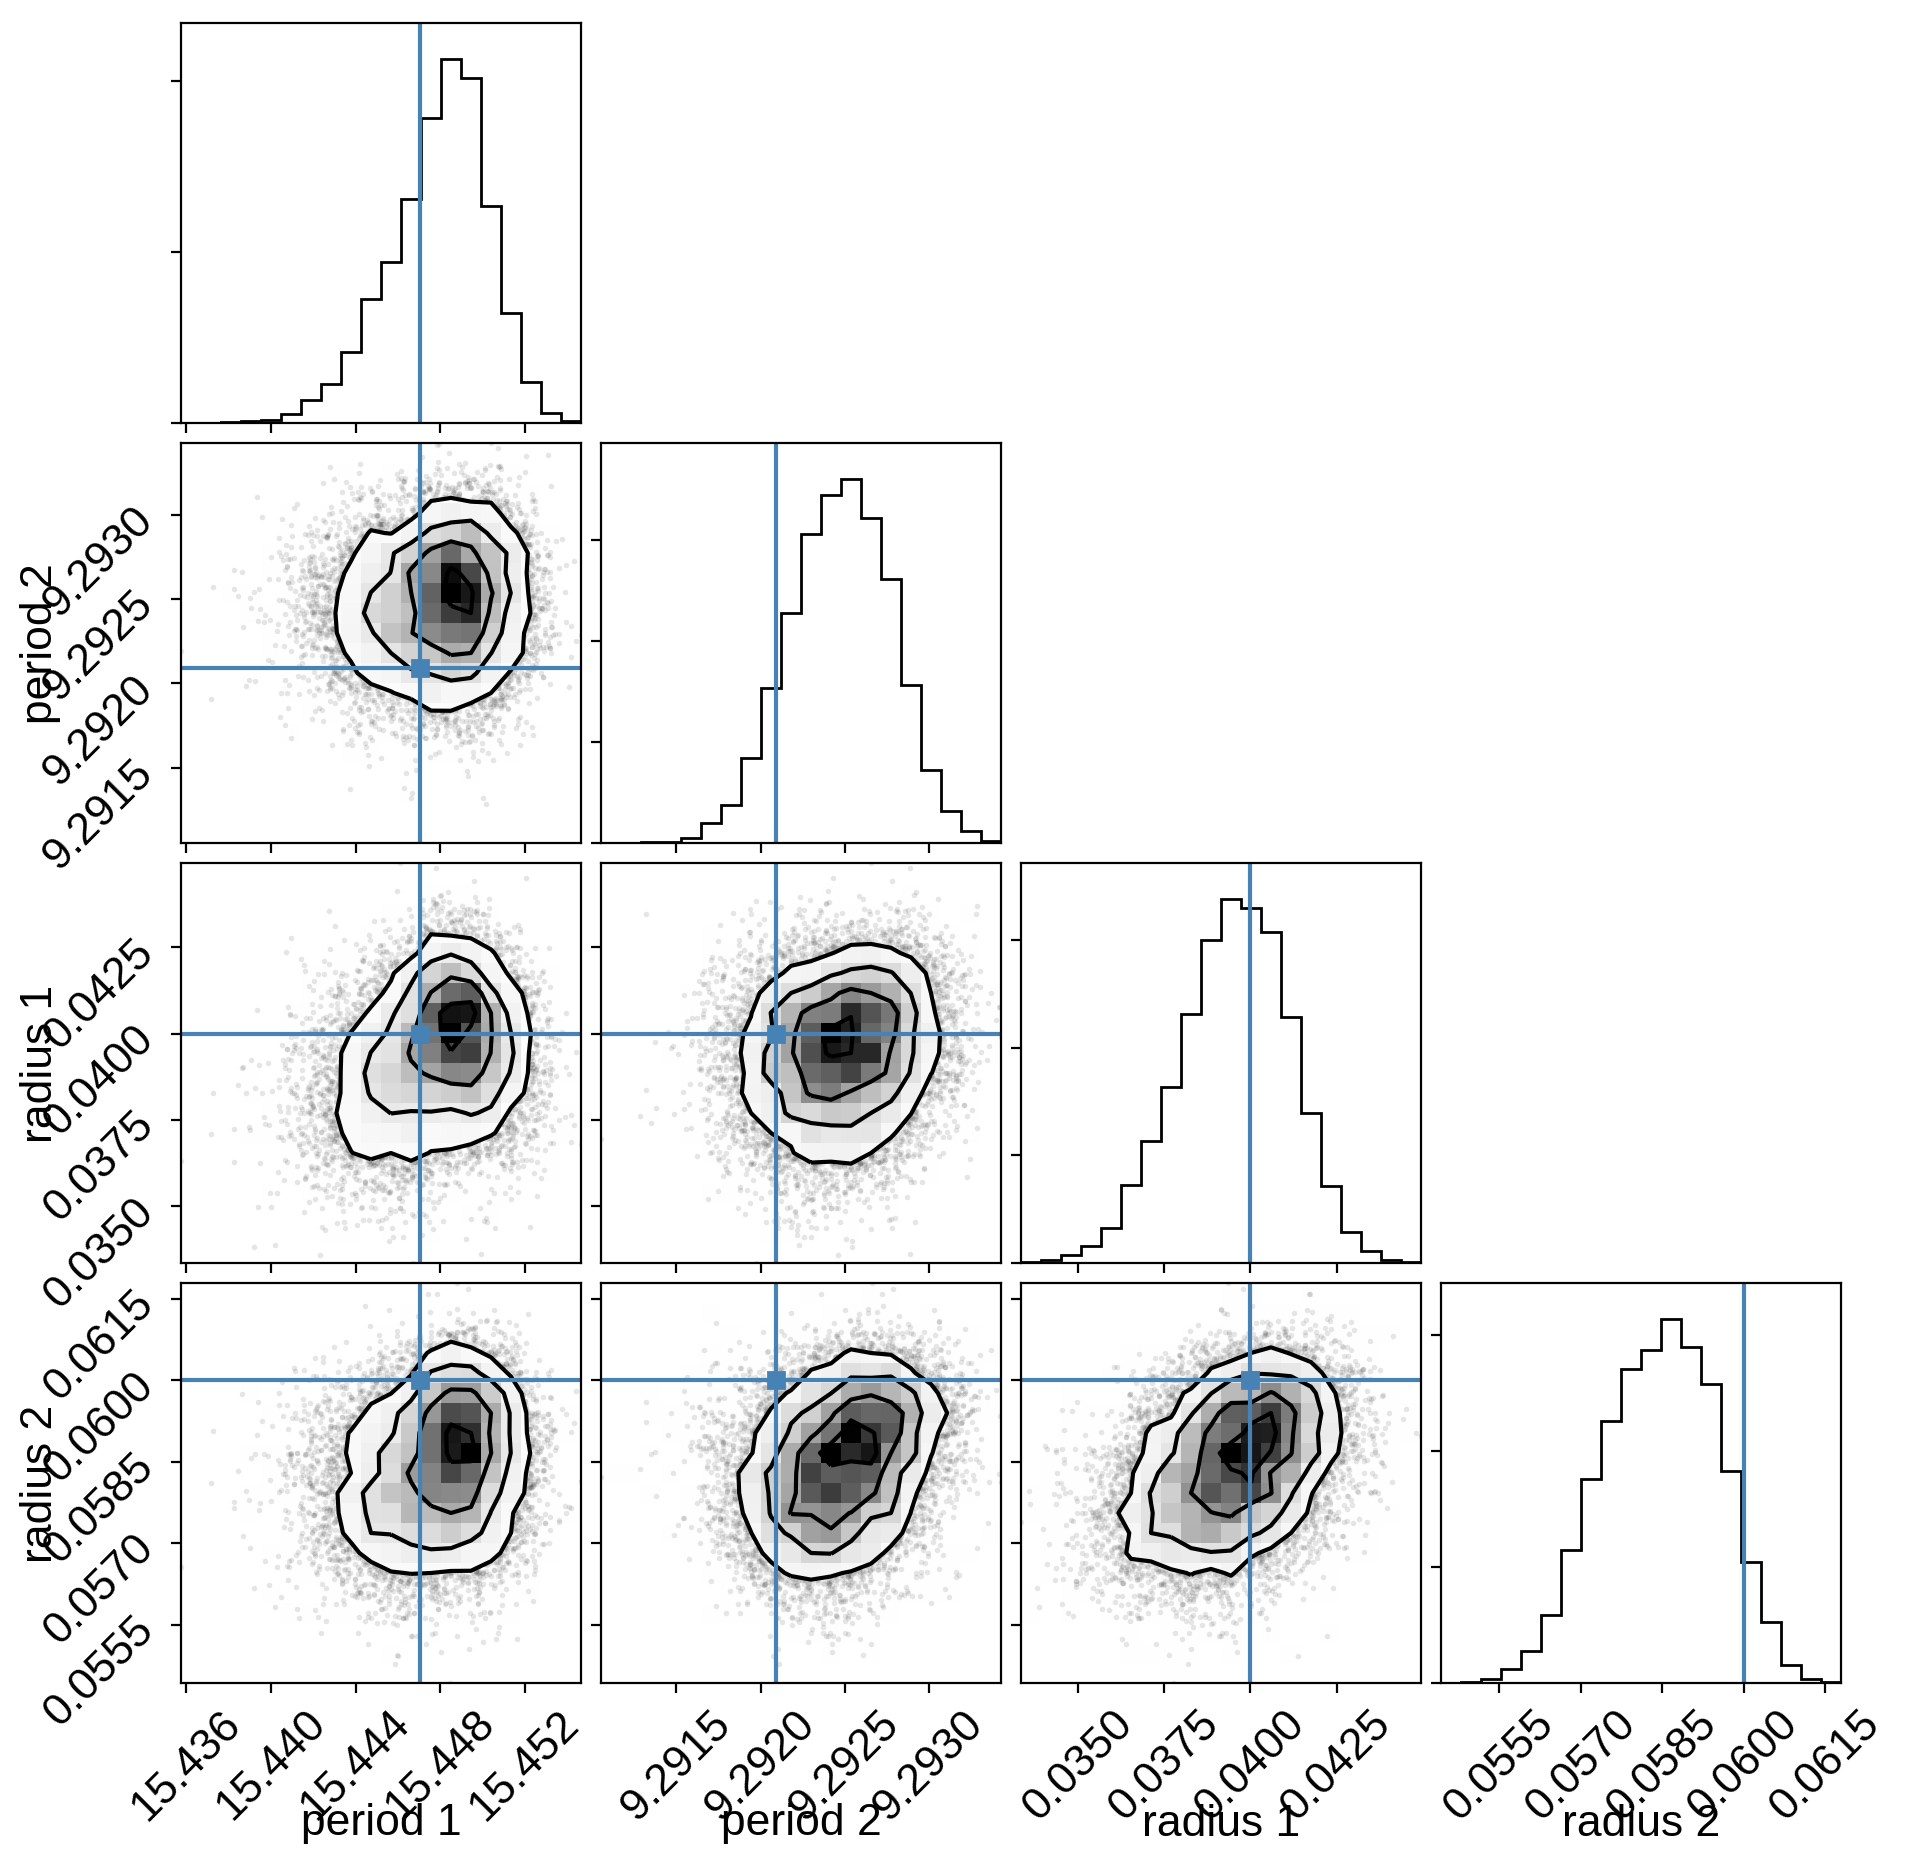

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

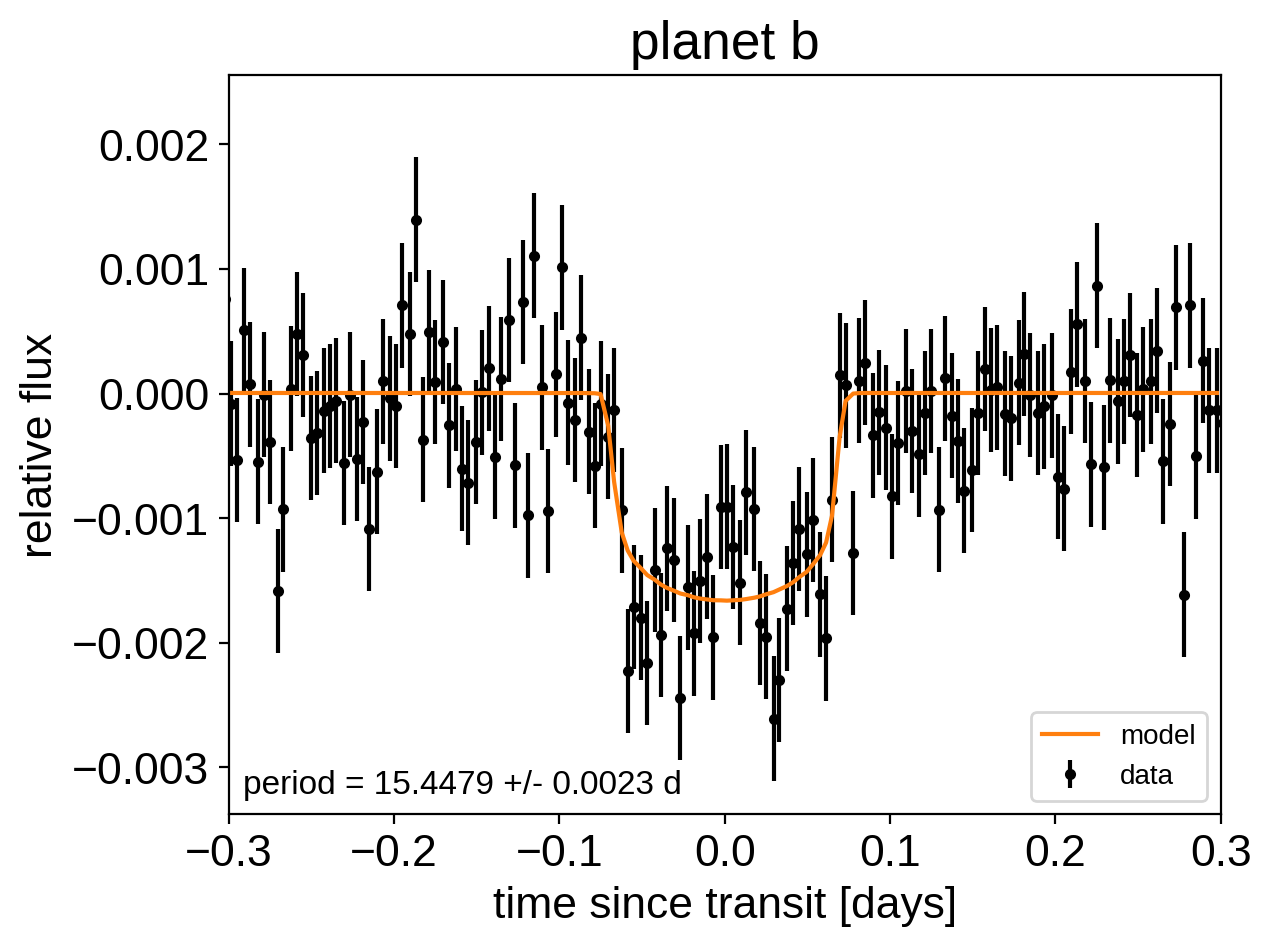

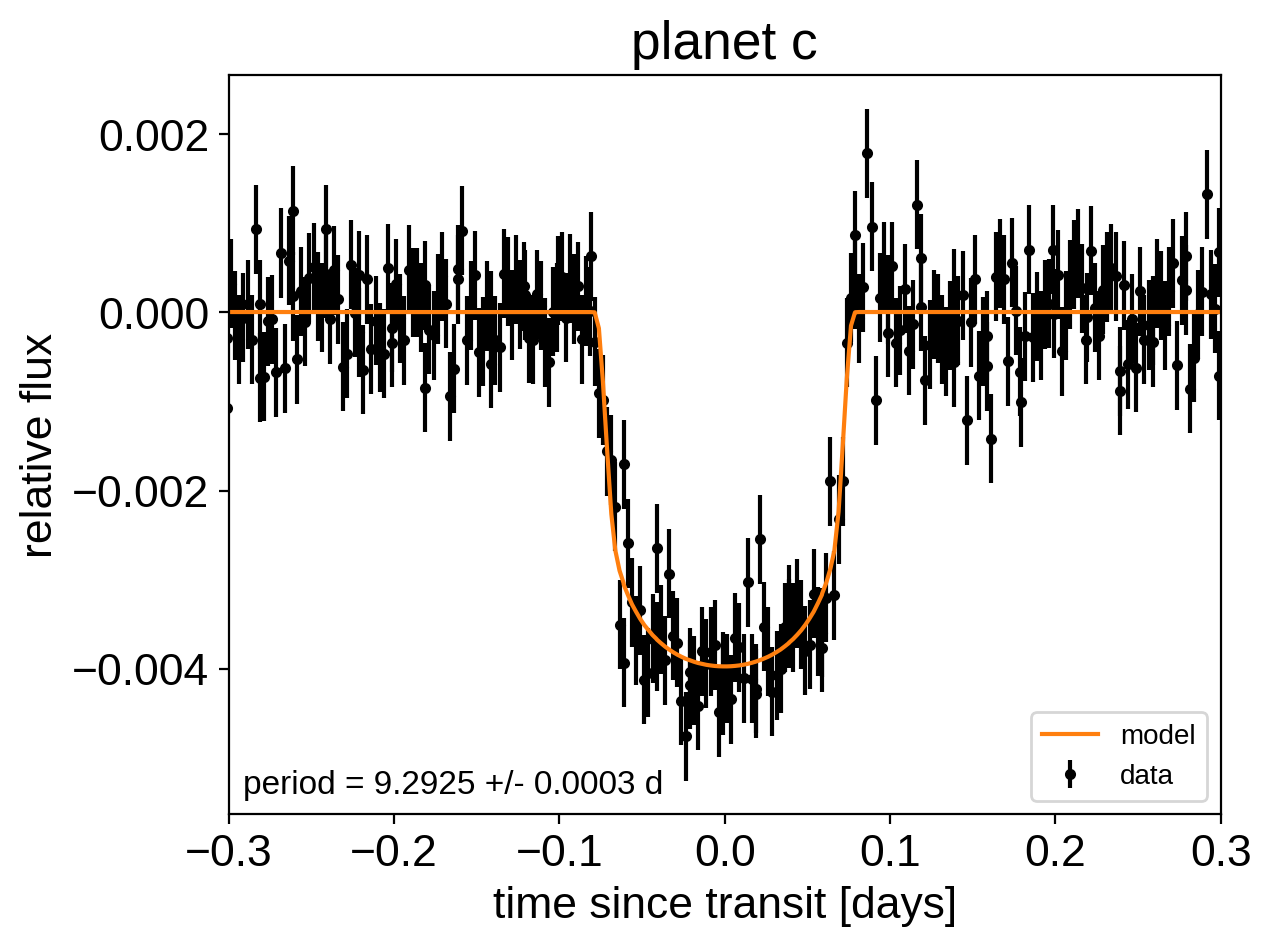

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
